# Analisis de experimentos de Escalabilidad y Latencia

A continuacion se realizara el analisis de resultados para el experimento de escalabilidad. El objetivo es validar si la tactica de arquitectura que se aplico para la solucion del ASR se rechaza o se cumple. El ASR que se tiene es:

- Manejar picos de hasta 10,000 órdenes por minuto (ventas y compras combinadas) durante eventos de alta demanda sin degradación en la latencia.

Para lograr lo anterior se asume que la arquitectura planteada es microservicios para el componente de procesamiento de ordenes. Para lo anterior se hace un mockup del endpoint que procesa dicho microservicio. El endpoint se muestra a continuacion

```python
@app.post("/order")
async def create_order(order: Order):
    """ Recepcion de ordenes de compra y venta.
    Este endpoint recibe una orden de compra o venta, valida el tipo de orden y la envia al broker Kafka. Se simula un tiempo de 30 ms para operaciones bloqueantes y 170 ms para operaciones asincronas.

    Args:
        order (Order): Orden de compra o venta

    Returns:
        dict: Mensaje de confirmacion de recepcion
    """
    # Validacion de tipo de orden
    print(f"Validating order: {order}")
    time.sleep(0.05)
    
    # Envio al broker kafka
    print(f"Sending order to Kafka: {order}")
    await asyncio.sleep(0.13)
    
    
    return {"message": "Order sent to Kafka", "order": order}

```


Notese que se esta simulando un endpoint en donde se cuenta con un proceso el cual bloquea el hilo alrededor de 50ms y adicionalmente se tiene un proceso que tardar 130ms pero no bloquea el proceso.

## Arquitectura planteada

Para la solucion de dicho ASR se aplica la tactica de arquitectura la cual consiste en un Application Load Balancer cuyo grupo objetivo es un cluster ECS de tipo FARGATE. La hipotesis que se tiene es:

- Se requiere un escalado horizontal de 12 tareas para soportar 10,000 peticiones en 60 segundos sin degradar la latencia (para nuestro escenario, que responde en menos de 200 ms)

### Experimentos

Como la hipotesis planteada 10,0000 peticiones para un escalado de 12 ECS Task. Debido a los costos, reestructuramos la misma hipotesis para que sea equivalente a 2 ECS Task, lo que euivale a 1680 peticiones por minutos.


- Experimento 1: Se lanza el cluster de ECS con 2 tareas. Se utiliza JMeter para generar trafico hacia el sistema. Se valida los resultados.
- Experimento 2: Se lanza el cluster de ECS con 4 tareas. Se utiliza JMeter para generar trafico hacia el sistema. Se valida los resultados.
- Experimento 3: Se lanza el cluster de ECS con 6 tareas. Se utiliza JMeter para generar trafico hacia el sistema. Se valida los resultados.

### Analisis de resultados

In [26]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [27]:
import pandas as pd
df_results_exp1 = pd.read_csv('../src/test/performance/result_exp3_scalability_2ecsTask_0.5vcpu2GBMemory.jtl')
df_results_exp2 = pd.read_csv('../src/test/performance/result_exp3_scalability_4ecsTask_0.5vcpu2GBMemory.jtl')
df_results_exp3 = pd.read_csv('../src/test/performance/result_exp3_scalability_6ecsTask_0.5vcpu2GBMemory.jtl')

In [28]:
df_results_exp1.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,1.680000e+03,1680.000000,1680.0,0.0,1680.0,1680.0,1680.000000,1680.000000,1680.000000,1680.0,1680.000000
mean,1.739978e+12,710.480952,200.0,NaN,255.0,292.0,27.209524,27.209524,710.468452,0.0,0.105952
std,1.262213e+04,239.146255,0.0,NaN,0.0,0.0,3.345879,3.345879,239.152749,0.0,1.740308
min,1.739978e+12,183.000000,200.0,NaN,255.0,292.0,1.000000,1.000000,183.000000,0.0,0.000000
25%,1.739978e+12,522.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,522.000000,0.0,0.000000
50%,1.739978e+12,678.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,678.000000,0.0,0.000000
75%,1.739978e+12,905.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,905.000000,0.0,0.000000
max,1.739978e+12,1554.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,1554.000000,0.0,33.000000


In [29]:
df_results_exp2.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,1.680000e+03,1680.000000,1680.0,0.0,1680.0,1680.0,1680.000000,1680.000000,1680.000000,1680.0,1680.000000
mean,1.739978e+12,356.055952,200.0,NaN,255.0,292.0,27.187500,27.187500,356.041667,0.0,0.067262
std,6.313454e+03,68.068427,0.0,NaN,0.0,0.0,3.230286,3.230286,68.069610,0.0,1.074752
min,1.739978e+12,183.000000,200.0,NaN,255.0,292.0,1.000000,1.000000,183.000000,0.0,0.000000
25%,1.739978e+12,310.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,310.000000,0.0,0.000000
50%,1.739978e+12,361.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,361.000000,0.0,0.000000
75%,1.739978e+12,408.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,408.000000,0.0,0.000000
max,1.739978e+12,536.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,536.000000,0.0,25.000000


In [30]:
df_results_exp3.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,1.680000e+03,1680.000000,1680.0,0.0,1680.0,1680.0,1680.000000,1680.000000,1680.000000,1680.0,1680.000000
mean,1.739978e+12,243.349405,200.0,NaN,255.0,292.0,26.408333,26.408333,243.336905,0.0,0.055357
std,4.354304e+03,38.582568,0.0,NaN,0.0,0.0,4.283150,4.283150,38.587581,0.0,1.060373
min,1.739978e+12,182.000000,200.0,NaN,255.0,292.0,1.000000,1.000000,182.000000,0.0,0.000000
25%,1.739978e+12,210.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,210.000000,0.0,0.000000
50%,1.739978e+12,232.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,232.000000,0.0,0.000000
75%,1.739978e+12,275.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,275.000000,0.0,0.000000
max,1.739978e+12,367.000000,200.0,NaN,255.0,292.0,28.000000,28.000000,367.000000,0.0,25.000000


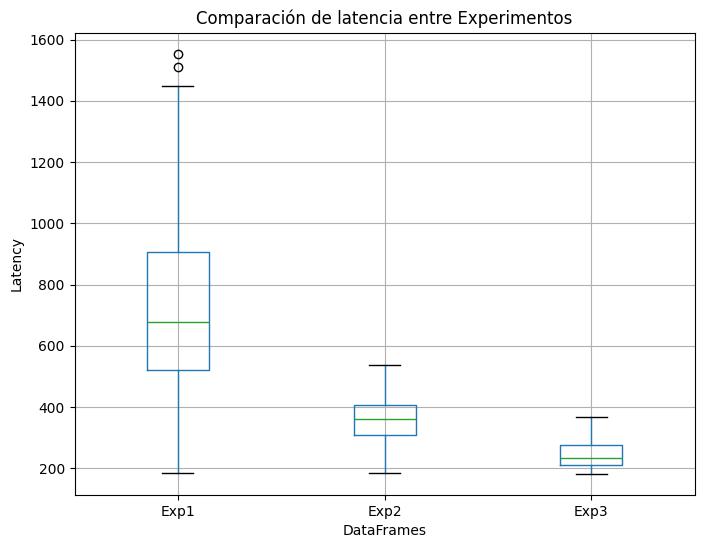

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Crear un DataFrame combinado para facilitar la visualización
data = {
    "Exp1": df_results_exp1["Latency"],
    "Exp2": df_results_exp2["Latency"],
    "Exp3": df_results_exp3["Latency"]
}

df_combined = pd.DataFrame(data)

# Crear el boxplot
plt.figure(figsize=(8, 6))
df_combined.boxplot()
plt.title("Comparación de latencia entre Experimentos")
plt.ylabel("Latency")
plt.xlabel("DataFrames")
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [32]:
df_combined

,Exp1,Exp2,Exp3
0,249,216,215
1,295,225,188
2,297,234,215
3,323,214,201
4,395,279,297
...,...,...,...
1675,184,184,185
1676,184,184,184
1677,184,183,183
1678,184,184,184
